# 🎶 Music Generation with Transformers

In [1]:
!bash scripts/download_music_data.sh

bash: scripts/download_music_data.sh: No such file or directory


In this notebook, we'll walk through the steps required to train your own Transformer model to generate music in the style of the Bach cello suites

In [6]:
%load_ext autoreload
%autoreload 2

import os
import glob
import numpy as np
import time
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, losses, callbacks

import music21

import os
import pickle as pkl
import music21
import keras
import tensorflow as tf

from fractions import Fraction


def parse_midi_files(file_list, parser, seq_len, parsed_data_path=None):
    notes_list = []
    duration_list = []
    notes = []
    durations = []

    for i, file in enumerate(file_list):
        print(i + 1, "Parsing %s" % file)
        score = parser.parse(file).chordify()

        notes.append("START")
        durations.append("0.0")

        for element in score.flat:
            note_name = None
            duration_name = None

            if isinstance(element, music21.key.Key):
                note_name = str(element.tonic.name) + ":" + str(element.mode)
                duration_name = "0.0"

            elif isinstance(element, music21.meter.TimeSignature):
                note_name = str(element.ratioString) + "TS"
                duration_name = "0.0"

            elif isinstance(element, music21.chord.Chord):
                note_name = element.pitches[-1].nameWithOctave
                duration_name = str(element.duration.quarterLength)

            elif isinstance(element, music21.note.Rest):
                note_name = str(element.name)
                duration_name = str(element.duration.quarterLength)

            elif isinstance(element, music21.note.Note):
                note_name = str(element.nameWithOctave)
                duration_name = str(element.duration.quarterLength)

            if note_name and duration_name:
                notes.append(note_name)
                durations.append(duration_name)
        print(f"{len(notes)} notes parsed")

    notes_list = []
    duration_list = []

    print(f"Building sequences of length {seq_len}")
    for i in range(len(notes) - seq_len):
        notes_list.append(" ".join(notes[i : (i + seq_len)]))
        duration_list.append(" ".join(durations[i : (i + seq_len)]))

    if parsed_data_path:
        with open(os.path.join(parsed_data_path, "notes"), "wb") as f:
            pkl.dump(notes_list, f)
        with open(os.path.join(parsed_data_path, "durations"), "wb") as f:
            pkl.dump(duration_list, f)

    return notes_list, duration_list


def load_parsed_files(parsed_data_path):
    with open(os.path.join(parsed_data_path, "notes"), "rb") as f:
        notes = pkl.load(f)
    with open(os.path.join(parsed_data_path, "durations"), "rb") as f:
        durations = pkl.load(f)
    return notes, durations


def get_midi_note(sample_note, sample_duration):
    new_note = None

    if "TS" in sample_note:
        new_note = music21.meter.TimeSignature(sample_note.split("TS")[0])

    elif "major" in sample_note or "minor" in sample_note:
        tonic, mode = sample_note.split(":")
        new_note = music21.key.Key(tonic, mode)

    elif sample_note == "rest":
        new_note = music21.note.Rest()
        new_note.duration = music21.duration.Duration(
            float(Fraction(sample_duration))
        )
        new_note.storedInstrument = music21.instrument.Violoncello()

    elif "." in sample_note:
        notes_in_chord = sample_note.split(".")
        chord_notes = []
        for current_note in notes_in_chord:
            n = music21.note.Note(current_note)
            n.duration = music21.duration.Duration(
                float(Fraction(sample_duration))
            )
            n.storedInstrument = music21.instrument.Violoncello()
            chord_notes.append(n)
        new_note = music21.chord.Chord(chord_notes)

    elif sample_note == "rest":
        new_note = music21.note.Rest()
        new_note.duration = music21.duration.Duration(
            float(Fraction(sample_duration))
        )
        new_note.storedInstrument = music21.instrument.Violoncello()

    elif sample_note != "START":
        new_note = music21.note.Note(sample_note)
        new_note.duration = music21.duration.Duration(
            float(Fraction(sample_duration))
        )
        new_note.storedInstrument = music21.instrument.Violoncello()

    return new_note


class SinePositionEncoding(keras.layers.Layer):
    """Sinusoidal positional encoding layer.
    This layer calculates the position encoding as a mix of sine and cosine
    functions with geometrically increasing wavelengths. Defined and formulized
    in [Attention is All You Need](https://arxiv.org/abs/1706.03762).
    Takes as input an embedded token tensor. The input must have shape
    [batch_size, sequence_length, feature_size]. This layer will return a
    positional encoding the same size as the embedded token tensor, which
    can be added directly to the embedded token tensor.
    Args:
        max_wavelength: The maximum angular wavelength of the sine/cosine
            curves, as described in Attention is All You Need. Defaults to
            10000.
    Examples:
    ```python
    # create a simple embedding layer with sinusoidal positional encoding
    seq_len = 100
    vocab_size = 1000
    embedding_dim = 32
    inputs = keras.Input((seq_len,), dtype=tf.float32)
    embedding = keras.layers.Embedding(
        input_dim=vocab_size, output_dim=embedding_dim
    )(inputs)
    positional_encoding = keras_nlp.layers.SinePositionEncoding()(embedding)
    outputs = embedding + positional_encoding
    ```
    References:
     - [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)
    """

    def __init__(
        self,
        max_wavelength=10000,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.max_wavelength = max_wavelength

    def call(self, inputs):
        # TODO(jbischof): replace `hidden_size` with`hidden_dim` for consistency
        # with other layers.
        input_shape = tf.shape(inputs)
        # length of sequence is the second last dimension of the inputs
        seq_length = input_shape[-2]
        hidden_size = input_shape[-1]
        position = tf.cast(tf.range(seq_length), self.compute_dtype)
        min_freq = tf.cast(1 / self.max_wavelength, dtype=self.compute_dtype)
        timescales = tf.pow(
            min_freq,
            tf.cast(2 * (tf.range(hidden_size) // 2), self.compute_dtype)
            / tf.cast(hidden_size, self.compute_dtype),
        )
        angles = tf.expand_dims(position, 1) * tf.expand_dims(timescales, 0)
        # even indices are sine, odd are cosine
        cos_mask = tf.cast(tf.range(hidden_size) % 2, self.compute_dtype)
        sin_mask = 1 - cos_mask
        # embedding shape is [seq_length, hidden_size]
        positional_encodings = (
            tf.sin(angles) * sin_mask + tf.cos(angles) * cos_mask
        )

        return tf.broadcast_to(positional_encodings, input_shape)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "max_wavelength": self.max_wavelength,
            }
        )
        return config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
!pip install music21

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.8/22.8 MB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 18.2 MB/s eta 0:00:00


In [4]:
!jupyter nbconvert --execute transformer_utils.ipynb

[NbConvertApp] WARNING | pattern 'transformer_utils.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execu

In [11]:
!git clone https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/11_music/01_transformer/transformer.ipynb


Cloning into 'transformer.ipynb'...
fatal: repository 'https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/11_music/01_transformer/transformer.ipynb/' not found


## 0. Parameters <a name="parameters"></a>

In [48]:
PARSE_MIDI_FILES = True
PARSED_DATA_PATH = "/app/notebooks/11_music/01_transformer/parsed_data/"
DATASET_REPETITIONS = 1

SEQ_LEN = 50
EMBEDDING_DIM = 256
KEY_DIM = 256
N_HEADS = 5
DROPOUT_RATE = 0.3
FEED_FORWARD_DIM = 256
LOAD_MODEL = False

# optimization
EPOCHS = 200
BATCH_SIZE = 256

GENERATE_LEN = 50

## 1. Prepare the Data

In [12]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving bwv1007.zip to bwv1007.zip
Saving bwv1008.zip to bwv1008.zip
Saving bwv1009.zip to bwv1009.zip
Saving bwv1010.zip to bwv1010.zip
Saving bwv1011.zip to bwv1011.zip
Saving bwv1012.zip to bwv1012.zip
User uploaded file "bwv1007.zip" with length 7206 bytes
User uploaded file "bwv1008.zip" with length 8021 bytes
User uploaded file "bwv1009.zip" with length 8783 bytes
User uploaded file "bwv1010.zip" with length 8622 bytes
User uploaded file "bwv1011.zip" with length 8973 bytes
User uploaded file "bwv1012.zip" with length 10242 bytes


In [15]:
import os
import zipfile

# Iterate over each file that was uploaded
for filename in uploaded.keys():
    # Check if the file is a zip file
    if filename.endswith('.zip'):
        # Construct the path to the zip file
        zip_path = os.path.join("/content", filename)
        # Construct the directory to which the files will be extracted
        extract_dir = os.path.join("/content", filename[:-4])  # Removing '.zip' from the filename
        os.makedirs(extract_dir, exist_ok=True)  # Create the directory if it doesn't exist

        # Unzip the file
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)

        print(f"Extracted {filename} to {extract_dir}")


Extracted bwv1007.zip to /content/bwv1007
Extracted bwv1008.zip to /content/bwv1008
Extracted bwv1009.zip to /content/bwv1009
Extracted bwv1010.zip to /content/bwv1010
Extracted bwv1011.zip to /content/bwv1011
Extracted bwv1012.zip to /content/bwv1012


In [18]:
import glob

# This pattern will match any .mid files in directories like /content/bwv1007, /content/bwv1008, etc.
file_list = glob.glob("/content/bwv*/**/*.mid", recursive=True)
print(f"Found {len(file_list)} MIDI files")


Found 36 MIDI files


In [19]:
parser = music21.converter

In [20]:
example_score = (
    music21.converter.parse(file_list[1]).splitAtQuarterLength(12)[0].chordify()
)

In [21]:
example_score.show()

SubConverterException: Cannot find a path to the 'mscore' file at /usr/bin/mscore3 -- download MuseScore

In [23]:
import music21

In [25]:
!which mscore

In [22]:
example_score.show("text")

{0.0} <music21.metadata.Metadata object at 0x7dbe542f4310>
{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.Violoncello 'Solo Cello: Solo Cello'>
    {0.0} <music21.instrument.Violoncello 'Violoncello'>
    {0.0} <music21.clef.BassClef>
    {0.0} <music21.tempo.MetronomeMark largo Quarter=45>
    {0.0} <music21.key.Key of F major>
    {0.0} <music21.meter.TimeSignature 3/4>
    {0.0} <music21.chord.Chord D3>
    {0.5} <music21.chord.Chord F3>
    {1.0} <music21.chord.Chord A3>
    {2.25} <music21.chord.Chord F3>
    {2.5} <music21.chord.Chord E3>
    {2.75} <music21.chord.Chord D3>
{3.0} <music21.stream.Measure 2 offset=3.0>
    {0.0} <music21.chord.Chord C#3>
    {0.25} <music21.chord.Chord E3>
    {0.5} <music21.chord.Chord G3>
    {0.75} <music21.chord.Chord A3>
    {1.0} <music21.chord.Chord B-3>
    {2.25} <music21.chord.Chord A3>
    {2.5} <music21.chord.Chord G3>
    {2.75} <music21.chord.Chord F3>
{6.0} <music21.stream.Measure 3 offset=6.0>
    {0.0} <m

In [27]:
import os

# Define the path to save parsed data within the Colab environment
PARSED_DATA_PATH = "/content/parsed_data/"

# Create the directory if it does not exist
os.makedirs(PARSED_DATA_PATH, exist_ok=True)

if PARSE_MIDI_FILES:
    notes, durations = parse_midi_files(
        file_list, parser, SEQ_LEN + 1, PARSED_DATA_PATH
    )
else:
    notes, durations = load_parsed_files()


1 Parsing /content/bwv1008/cs2-6gig.mid


<ipython-input-27-1f04502ee305>:10: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  notes, durations = parse_midi_files(


735 notes parsed
2 Parsing /content/bwv1008/cs2-1pre.mid
1373 notes parsed
3 Parsing /content/bwv1008/cs2-2all.mid
2066 notes parsed
4 Parsing /content/bwv1008/cs2-4sar.mid
2403 notes parsed
5 Parsing /content/bwv1008/cs2-3cou.mid
3144 notes parsed
6 Parsing /content/bwv1008/cs2-5men.mid
3671 notes parsed
7 Parsing /content/bwv1012/cs6-6gig.mid
4843 notes parsed
8 Parsing /content/bwv1012/cs6-2all.mid
5528 notes parsed
9 Parsing /content/bwv1012/cs6-5gav.mid
6334 notes parsed
10 Parsing /content/bwv1012/cs6-4sar.mid
6669 notes parsed
11 Parsing /content/bwv1012/cs6-1pre.mid
8011 notes parsed
12 Parsing /content/bwv1012/cs6-3cou.mid
9297 notes parsed
13 Parsing /content/bwv1007/cs1-2all.mid
10218 notes parsed
14 Parsing /content/bwv1007/cs1-5men.mid
10865 notes parsed
15 Parsing /content/bwv1007/cs1-3cou.mid
11685 notes parsed
16 Parsing /content/bwv1007/cs1-6gig.mid
12111 notes parsed
17 Parsing /content/bwv1007/cs1-1pre.mid
12769 notes parsed
18 Parsing /content/bwv1007/cs1-4sar.mid
1

In [28]:
example_notes = notes[658]
example_durations = durations[658]
print("\nNotes string\n", example_notes, "...")
print("\nDuration string\n", example_durations, "...")


Notes string
 G3 E3 D3 E3 F3 D3 G3 E3 D3 E3 F3 D3 G3 E3 C#3 B-3 A3 G3 F3 E3 F2 A3 G3 F3 E3 C#3 D3 B-2 A2 G2 A2 F2 D2 A2 D3 E3 F3 D3 E-3 F3 G3 E-3 F3 D3 G3 A3 B-3 G3 A3 F3 E-3 ...

Duration string
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 ...


## 2. Tokenize the data <a name="tokenize"></a>

In [29]:
def create_dataset(elements):
    ds = (
        tf.data.Dataset.from_tensor_slices(elements)
        .batch(BATCH_SIZE, drop_remainder=True)
        .shuffle(1000)
    )
    vectorize_layer = layers.TextVectorization(
        standardize=None, output_mode="int"
    )
    vectorize_layer.adapt(ds)
    vocab = vectorize_layer.get_vocabulary()
    return ds, vectorize_layer, vocab


notes_seq_ds, notes_vectorize_layer, notes_vocab = create_dataset(notes)
durations_seq_ds, durations_vectorize_layer, durations_vocab = create_dataset(
    durations
)
seq_ds = tf.data.Dataset.zip((notes_seq_ds, durations_seq_ds))

In [30]:
# Display the same example notes and durations converted to ints
example_tokenised_notes = notes_vectorize_layer(example_notes)
example_tokenised_durations = durations_vectorize_layer(example_durations)
print("{:10} {:10}".format("note token", "duration token"))
for i, (note_int, duration_int) in enumerate(
    zip(
        example_tokenised_notes.numpy()[:11],
        example_tokenised_durations.numpy()[:11],
    )
):
    print(f"{note_int:10}{duration_int:10}")

note token duration token
         2         2
         8         2
         4         2
         8         2
         5         2
         4         2
         2         2
         8         2
         4         2
         8         2
         5         2


In [31]:
notes_vocab_size = len(notes_vocab)
durations_vocab_size = len(durations_vocab)

# Display some token:note mappings
print(f"\nNOTES_VOCAB: length = {len(notes_vocab)}")
for i, note in enumerate(notes_vocab[:10]):
    print(f"{i}: {note}")

print(f"\nDURATIONS_VOCAB: length = {len(durations_vocab)}")
# Display some token:duration mappings
for i, note in enumerate(durations_vocab[:10]):
    print(f"{i}: {note}")


NOTES_VOCAB: length = 59
0: 
1: [UNK]
2: G3
3: A3
4: D3
5: F3
6: C4
7: D4
8: E3
9: B3

DURATIONS_VOCAB: length = 24
0: 
1: [UNK]
2: 0.25
3: 0.5
4: 1.0
5: 1/3
6: 0.75
7: 1/12
8: 1.5
9: 0.0


## 3. Create the Training Set <a name="create"></a>

In [32]:
# Create the training set of sequences and the same sequences shifted by one note
def prepare_inputs(notes, durations):
    notes = tf.expand_dims(notes, -1)
    durations = tf.expand_dims(durations, -1)
    tokenized_notes = notes_vectorize_layer(notes)
    tokenized_durations = durations_vectorize_layer(durations)
    x = (tokenized_notes[:, :-1], tokenized_durations[:, :-1])
    y = (tokenized_notes[:, 1:], tokenized_durations[:, 1:])
    return x, y


ds = seq_ds.map(prepare_inputs).repeat(DATASET_REPETITIONS)

In [33]:
example_input_output = ds.take(1).get_single_element()
print(example_input_output)

((<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[ 9,  6,  3, ..., 19,  4,  8],
       [ 6,  3,  2, ...,  4,  8,  5],
       [ 3,  2,  8, ...,  8,  5, 26],
       ...,
       [12,  8,  4, ...,  8,  4, 13],
       [ 8,  4, 12, ...,  4, 13, 18],
       [ 4, 12, 13, ..., 13, 18,  4]])>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[2, 2, 2, ..., 3, 3, 3],
       [2, 2, 2, ..., 3, 3, 3],
       [2, 2, 2, ..., 3, 3, 4],
       ...,
       [2, 2, 2, ..., 3, 3, 3],
       [2, 2, 2, ..., 3, 3, 2],
       [2, 2, 2, ..., 3, 2, 2]])>), (<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[ 6,  3,  2, ...,  4,  8,  5],
       [ 3,  2,  8, ...,  8,  5, 26],
       [ 2,  8, 13, ...,  5, 26,  5],
       ...,
       [ 8,  4, 12, ...,  4, 13, 18],
       [ 4, 12, 13, ..., 13, 18,  4],
       [12, 13, 12, ..., 18,  4, 19]])>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[2, 2, 2, ..., 3, 3, 3],
       [2, 2, 2, ..., 3, 3, 4],
       [2, 2, 2, ..., 3, 4, 3],
       ...,

## 5. Create the causal attention mask function <a name="causal"></a>

In [34]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)


np.transpose(causal_attention_mask(1, 10, 10, dtype=tf.int32)[0])

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

## 6. Create a Transformer Block layer <a name="transformer"></a>

In [35]:
class TransformerBlock(layers.Layer):
    def __init__(
        self,
        num_heads,
        key_dim,
        embed_dim,
        ff_dim,
        name,
        dropout_rate=DROPOUT_RATE,
    ):
        super(TransformerBlock, self).__init__(name=name)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        self.attn = layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim
        )
        self.dropout_1 = layers.Dropout(self.dropout_rate)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation="relu")
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(self.dropout_rate)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(
            batch_size, seq_len, seq_len, tf.bool
        )
        attention_output, attention_scores = self.attn(
            inputs,
            inputs,
            attention_mask=causal_mask,
            return_attention_scores=True,
        )
        attention_output = self.dropout_1(attention_output)
        out1 = self.ln_1(inputs + attention_output)
        ffn_1 = self.ffn_1(out1)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        return (self.ln_2(out1 + ffn_output), attention_scores)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
                "dropout_rate": self.dropout_rate,
            }
        )
        return config

## 7. Create the Token and Position Embedding <a name="embedder"></a>

In [36]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            embeddings_initializer="he_uniform",
        )
        self.pos_emb = SinePositionEncoding()

    def call(self, x):
        embedding = self.token_emb(x)
        positions = self.pos_emb(embedding)
        return embedding + positions

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

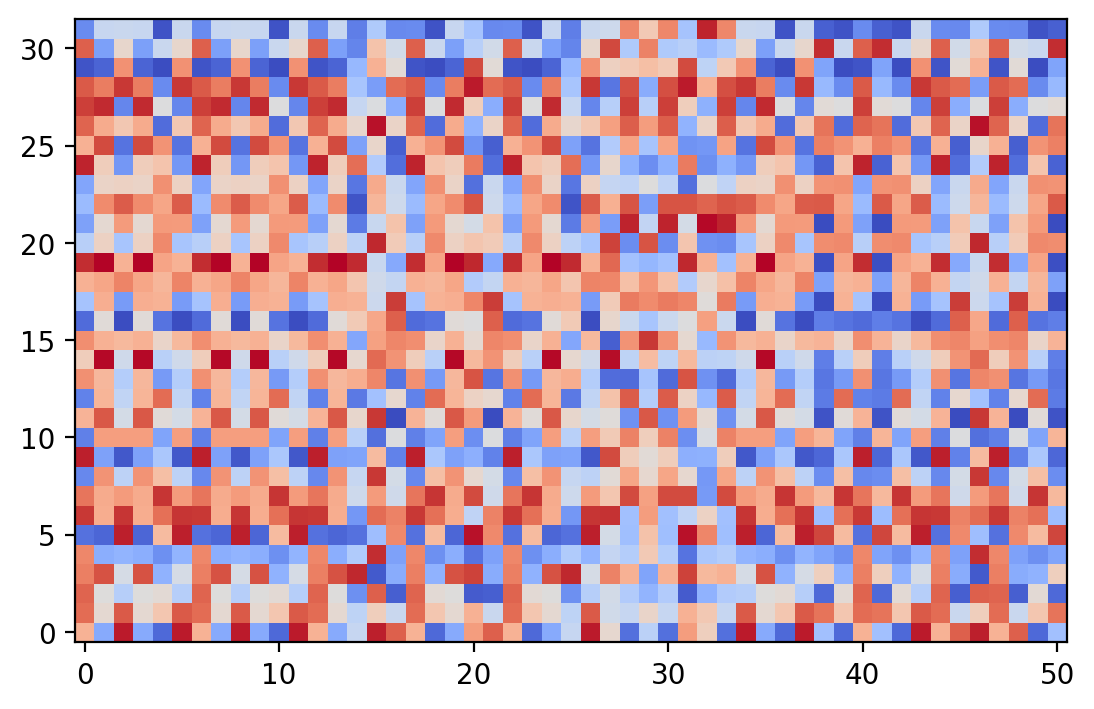

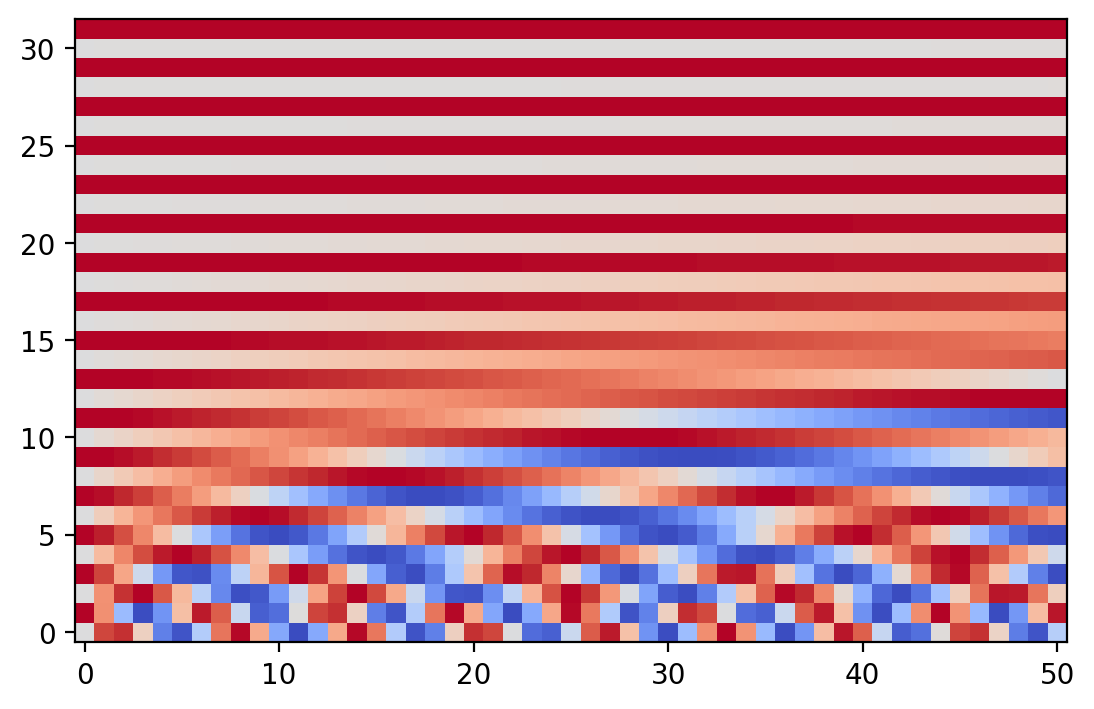

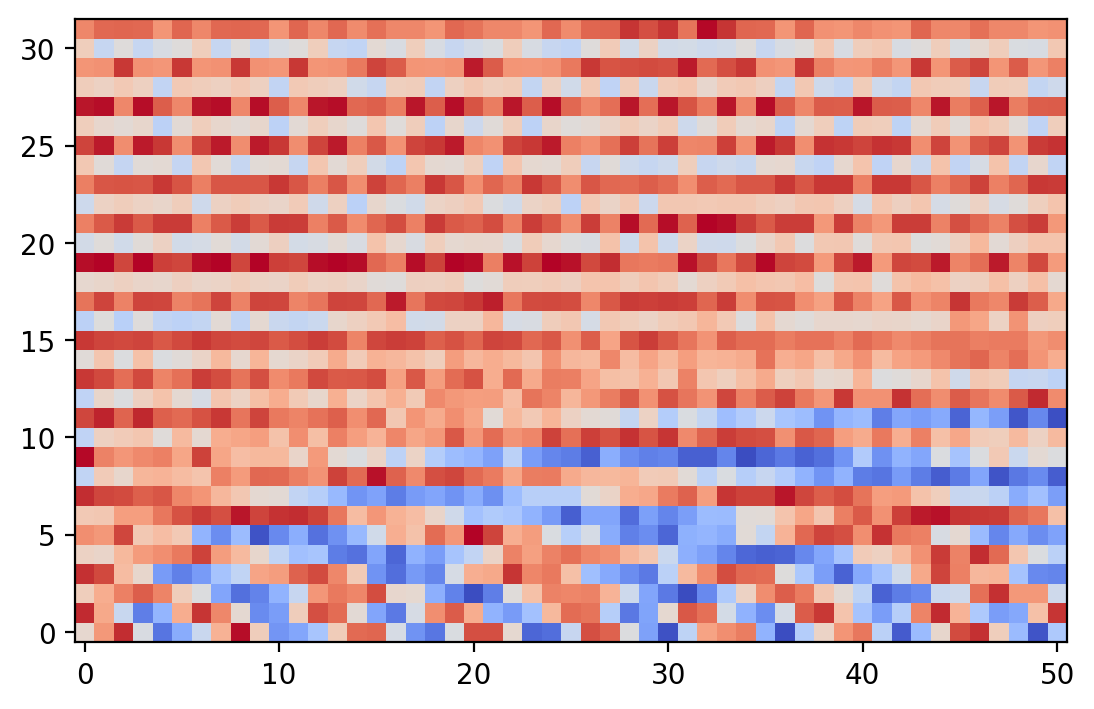

In [37]:
tpe = TokenAndPositionEmbedding(notes_vocab_size, 32)
token_embedding = tpe.token_emb(example_tokenised_notes)
position_embedding = tpe.pos_emb(token_embedding)
embedding = tpe(example_tokenised_notes)
plt.imshow(
    np.transpose(token_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(position_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()

## 8. Build the Transformer model <a name="transformer_decoder"></a>

In [38]:
note_inputs = layers.Input(shape=(None,), dtype=tf.int32)
durations_inputs = layers.Input(shape=(None,), dtype=tf.int32)
note_embeddings = TokenAndPositionEmbedding(
    notes_vocab_size, EMBEDDING_DIM // 2
)(note_inputs)
duration_embeddings = TokenAndPositionEmbedding(
    durations_vocab_size, EMBEDDING_DIM // 2
)(durations_inputs)
embeddings = layers.Concatenate()([note_embeddings, duration_embeddings])
x, attention_scores = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM, name="attention"
)(embeddings)
note_outputs = layers.Dense(
    notes_vocab_size, activation="softmax", name="note_outputs"
)(x)
duration_outputs = layers.Dense(
    durations_vocab_size, activation="softmax", name="duration_outputs"
)(x)
model = models.Model(
    inputs=[note_inputs, durations_inputs],
    outputs=[note_outputs, duration_outputs],  # attention_scores
)
model.compile(
    "adam",
    loss=[
        losses.SparseCategoricalCrossentropy(),
        losses.SparseCategoricalCrossentropy(),
    ],
)
att_model = models.Model(
    inputs=[note_inputs, durations_inputs], outputs=attention_scores
)

In [39]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 token_and_position_embeddi  (None, None, 128)            7552      ['input_1[0][0]']             
 ng_1 (TokenAndPositionEmbe                                                                       
 dding)                                                                                           
                                                                                              

In [40]:
if LOAD_MODEL:
    model.load_weights("./checkpoint/checkpoint.ckpt")
    # model = models.load_model('./models/model', compile=True)

## 9. Train the Transformer <a name="train"></a>

In [41]:
# Create a MusicGenerator checkpoint
class MusicGenerator(callbacks.Callback):
    def __init__(self, index_to_note, index_to_duration, top_k=10):
        self.index_to_note = index_to_note
        self.note_to_index = {
            note: index for index, note in enumerate(index_to_note)
        }
        self.index_to_duration = index_to_duration
        self.duration_to_index = {
            duration: index for index, duration in enumerate(index_to_duration)
        }

    def sample_from(self, probs, temperature):
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def get_note(self, notes, durations, temperature):
        sample_note_idx = 1
        while sample_note_idx == 1:
            sample_note_idx, note_probs = self.sample_from(
                notes[0][-1], temperature
            )
            sample_note = self.index_to_note[sample_note_idx]

        sample_duration_idx = 1
        while sample_duration_idx == 1:
            sample_duration_idx, duration_probs = self.sample_from(
                durations[0][-1], temperature
            )
            sample_duration = self.index_to_duration[sample_duration_idx]

        new_note = get_midi_note(sample_note, sample_duration)

        return (
            new_note,
            sample_note_idx,
            sample_note,
            note_probs,
            sample_duration_idx,
            sample_duration,
            duration_probs,
        )

    def generate(self, start_notes, start_durations, max_tokens, temperature):
        attention_model = models.Model(
            inputs=self.model.input,
            outputs=self.model.get_layer("attention").output,
        )

        start_note_tokens = [self.note_to_index.get(x, 1) for x in start_notes]
        start_duration_tokens = [
            self.duration_to_index.get(x, 1) for x in start_durations
        ]
        sample_note = None
        sample_duration = None
        info = []
        midi_stream = music21.stream.Stream()

        midi_stream.append(music21.clef.BassClef())

        for sample_note, sample_duration in zip(start_notes, start_durations):
            new_note = get_midi_note(sample_note, sample_duration)
            if new_note is not None:
                midi_stream.append(new_note)

        while len(start_note_tokens) < max_tokens:
            x1 = np.array([start_note_tokens])
            x2 = np.array([start_duration_tokens])
            notes, durations = self.model.predict([x1, x2], verbose=0)

            repeat = True

            while repeat:
                (
                    new_note,
                    sample_note_idx,
                    sample_note,
                    note_probs,
                    sample_duration_idx,
                    sample_duration,
                    duration_probs,
                ) = self.get_note(notes, durations, temperature)

                if (
                    isinstance(new_note, music21.chord.Chord)
                    or isinstance(new_note, music21.note.Note)
                    or isinstance(new_note, music21.note.Rest)
                ) and sample_duration == "0.0":
                    repeat = True
                else:
                    repeat = False

            if new_note is not None:
                midi_stream.append(new_note)

            _, att = attention_model.predict([x1, x2], verbose=0)

            info.append(
                {
                    "prompt": [start_notes.copy(), start_durations.copy()],
                    "midi": midi_stream,
                    "chosen_note": (sample_note, sample_duration),
                    "note_probs": note_probs,
                    "duration_probs": duration_probs,
                    "atts": att[0, :, -1, :],
                }
            )
            start_note_tokens.append(sample_note_idx)
            start_duration_tokens.append(sample_duration_idx)
            start_notes.append(sample_note)
            start_durations.append(sample_duration)

            if sample_note == "START":
                break

        return info

    def on_epoch_end(self, epoch, logs=None):
        info = self.generate(
            ["START"], ["0.0"], max_tokens=GENERATE_LEN, temperature=0.5
        )
        midi_stream = info[-1]["midi"].chordify()
        print(info[-1]["prompt"])
        midi_stream.show()
        midi_stream.write(
            "midi",
            fp=os.path.join(
                "/app/notebooks/11_music/01_transformer/output",
                "output-" + str(epoch).zfill(4) + ".mid",
            ),
        )

In [42]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

# Tokenize starting prompt
music_generator = MusicGenerator(notes_vocab, durations_vocab)

In [45]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [46]:
from music21 import stream

# Assume `s` is a music21 stream object
s = stream.Stream()

# ... your code to populate the stream ...

# Save to MIDI file
midi_path = '/content/drive/My Drive/generated_music.midi'
s.write('midi', fp=midi_path)


'/content/drive/My Drive/generated_music.midi'

In [50]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_callback = EarlyStopping(monitor='loss', patience=5)


model.fit(
    ds,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        early_stopping_callback,
    ],
)

Epoch 1/200
107/107 [==============================] - 55s 515ms/step - loss: 3.2708 - note_outputs_loss: 2.6582 - duration_outputs_loss: 0.6126
Epoch 2/200
107/107 [==============================] - 56s 522ms/step - loss: 3.1808 - note_outputs_loss: 2.5831 - duration_outputs_loss: 0.5977
Epoch 3/200
107/107 [==============================] - 56s 527ms/step - loss: 3.1283 - note_outputs_loss: 2.5370 - duration_outputs_loss: 0.5913
Epoch 4/200
107/107 [==============================] - 56s 524ms/step - loss: 3.0543 - note_outputs_loss: 2.4896 - duration_outputs_loss: 0.5647
Epoch 5/200
107/107 [==============================] - 56s 526ms/step - loss: 3.0234 - note_outputs_loss: 2.4646 - duration_outputs_loss: 0.5588
Epoch 6/200
107/107 [==============================] - 56s 520ms/step - loss: 2.9987 - note_outputs_loss: 2.4386 - duration_outputs_loss: 0.5602
Epoch 7/200
107/107 [==============================] - 56s 523ms/step - loss: 2.9767 - note_outputs_loss: 2.4206 - duration_output

In [51]:
# Save the final model
model.save("./models/model")

# 3. Generate music using the Transformer

In [61]:
from music21 import midi

info = music_generator.generate(
    ["START"], ["0.5"], max_tokens=50, temperature=0.7
)
midi_stream = info[-1]["midi"].chordify()

# Save the MIDI file
output_midi_path = '/content/generated_music.midi'
mf = midi.translate.music21ObjectToMidiFile(midi_stream)
mf.open(output_midi_path, 'wb')
mf.write()
mf.close()

print(f"MIDI file saved as {output_midi_path}")

# Make it downloadable
from google.colab import files
files.download(output_midi_path)


MIDI file saved as /content/generated_music.midi


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [52]:
info = music_generator.generate(
    ["START"], ["0.5"], max_tokens=50, temperature=0.7
)
midi_stream = info[-1]["midi"].chordify()
midi_stream.show()

SubConverterException: Cannot find a path to the 'mscore' file at /usr/bin/mscore3 -- download MuseScore

## Write music to MIDI file

In [55]:
import os
import time
from music21 import midi

# Create a directory for output if it doesn't exist
output_dir = '/content/output'
os.makedirs(output_dir, exist_ok=True)

# Generate the timestamped filename
timestr = time.strftime("%Y%m%d-%H%M%S")
output_path = os.path.join(output_dir, f"output-{timestr}.mid")

# Write the MIDI file to the new path
midi_stream.write("midi", fp=output_path)

print(f"MIDI file saved as {output_path}")


MIDI file saved as /content/output/output-20240411-203817.mid


## Note probabilities

In [56]:
max_pitch = 70
seq_len = len(info)
grid = np.zeros((max_pitch, seq_len), dtype=np.float32)

for j in range(seq_len):
    for i, prob in enumerate(info[j]["note_probs"]):
        try:
            pitch = music21.note.Note(notes_vocab[i]).pitch.midi
            grid[pitch, j] = prob
        except:
            pass  # Don't show key / time signatures

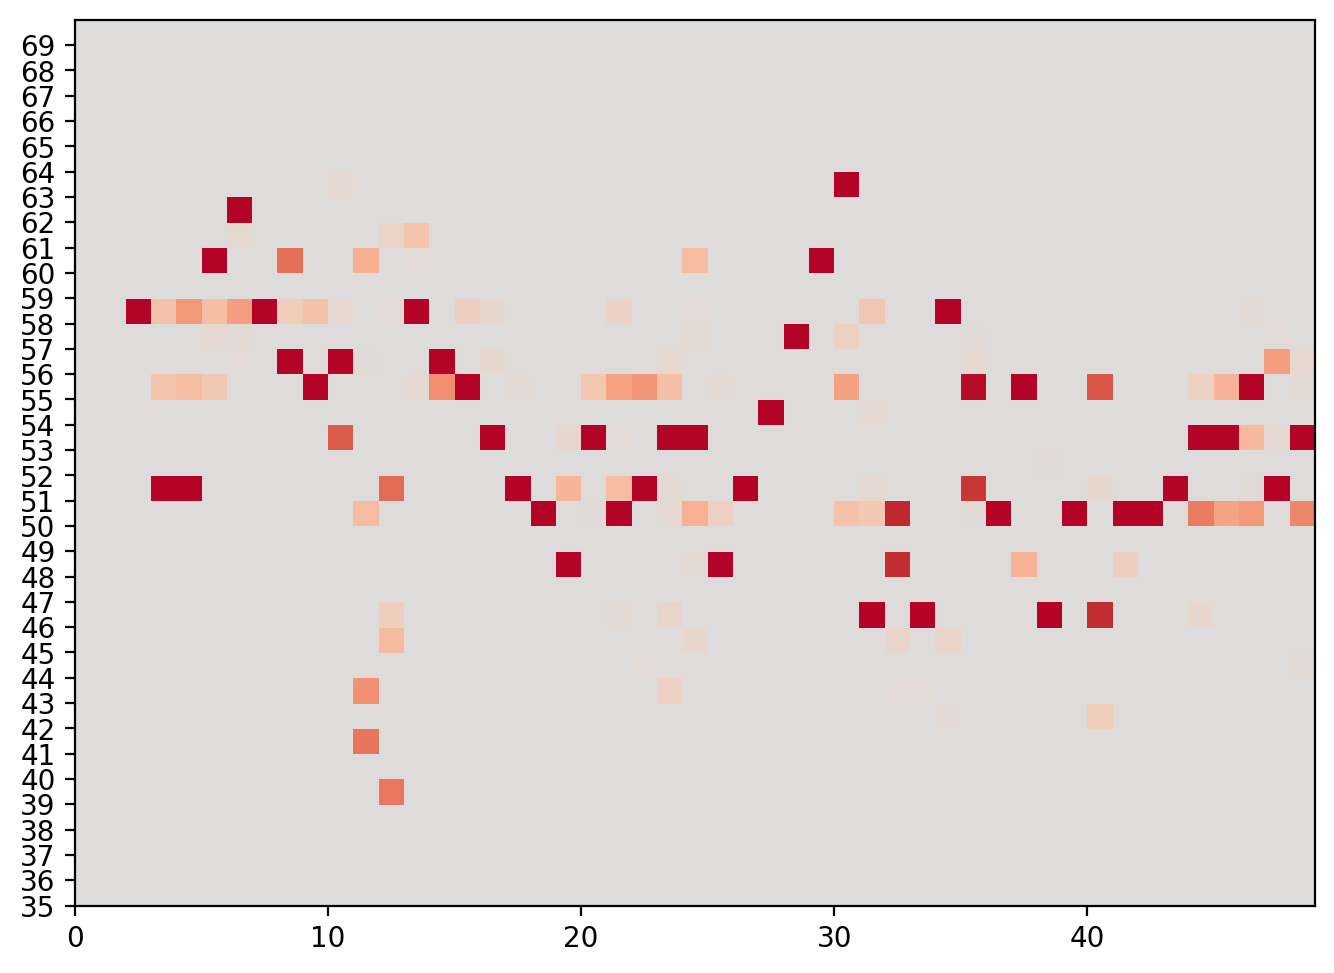

In [57]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_yticks([int(j) for j in range(35, 70)])
plt.imshow(
    grid[35:70, :],
    origin="lower",
    cmap="coolwarm",
    vmin=-0.5,
    vmax=0.5,
    extent=[0, seq_len, 35, 70],
)
plt.show()

## Attention Plot

In [58]:
plot_size = 20

att_matrix = np.zeros((plot_size, plot_size))
prediction_output = []
last_prompt = []

In [59]:
for j in range(plot_size):
    atts = info[j]["atts"].max(axis=0)
    att_matrix[: (j + 1), j] = atts
    prediction_output.append(info[j]["chosen_note"][0])
    last_prompt.append(info[j]["prompt"][0][-1])

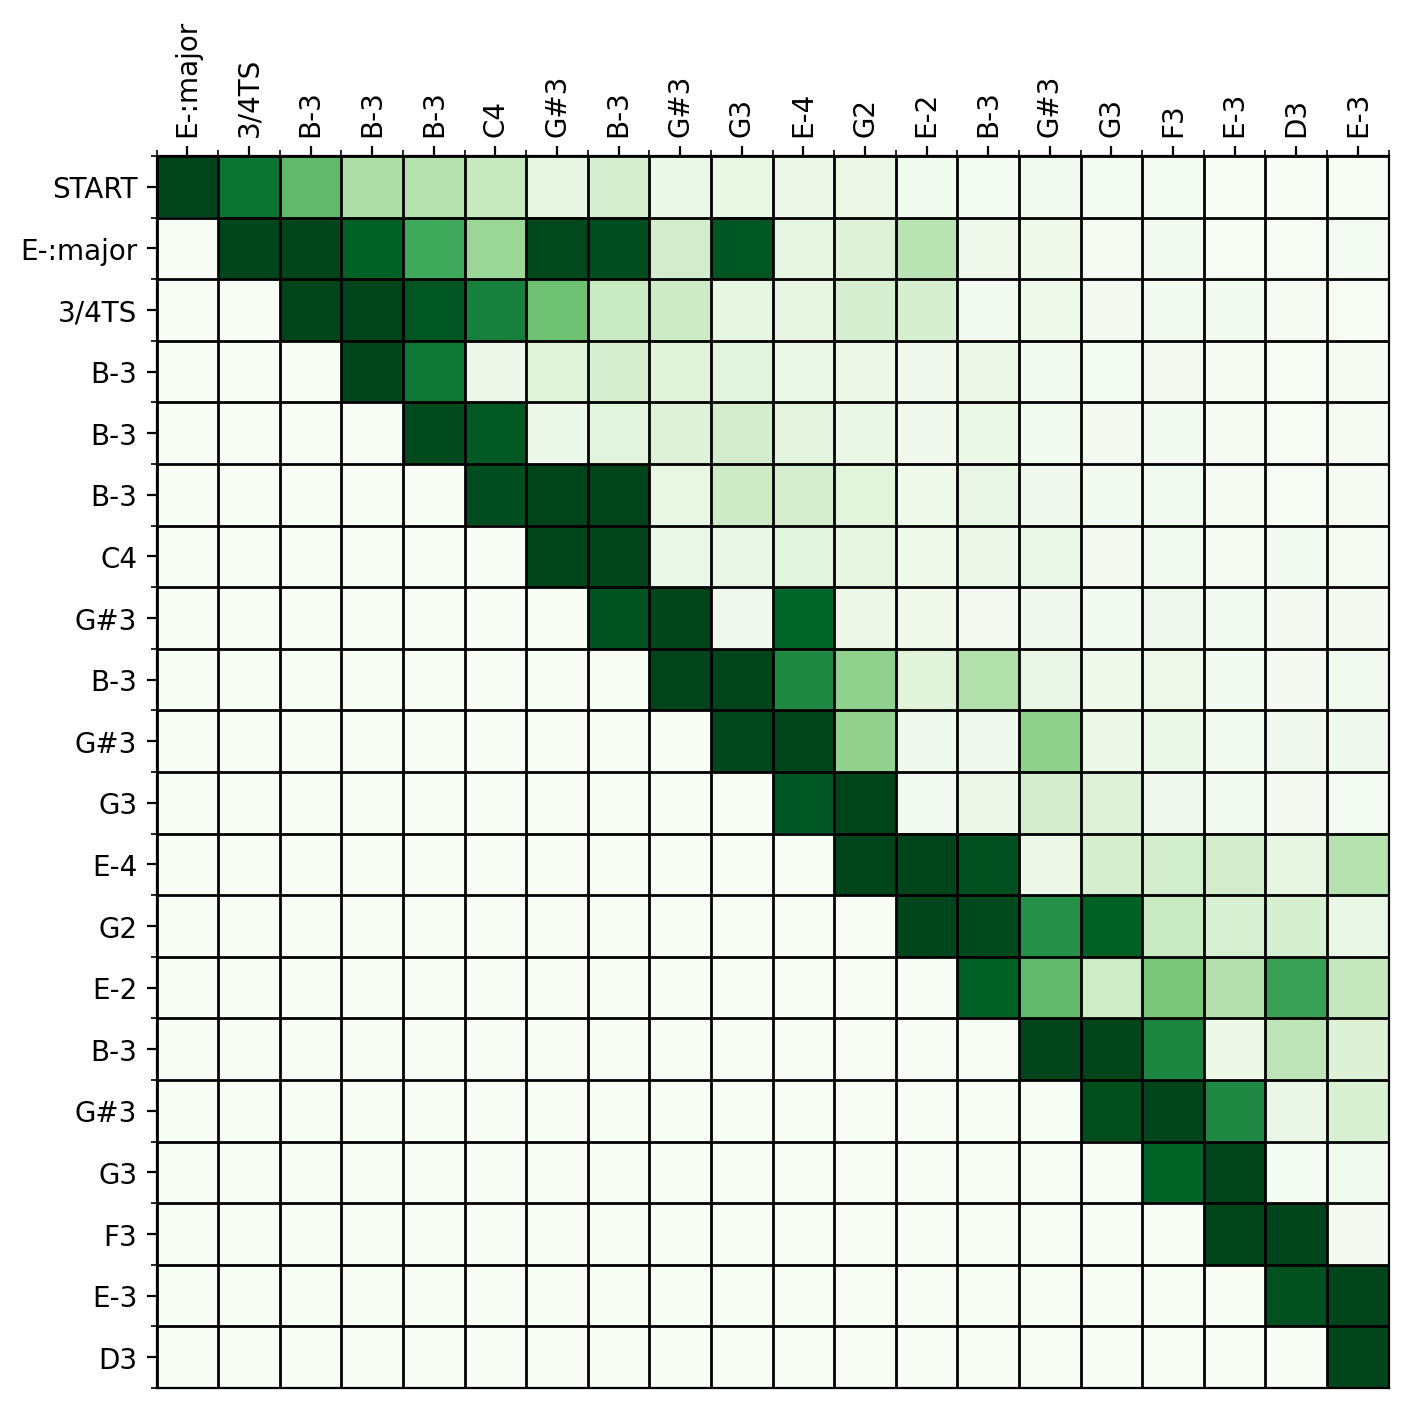

In [60]:
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(att_matrix, cmap="Greens", interpolation="nearest")

ax.set_xticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.set_yticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.grid(which="minor", color="black", linestyle="-", linewidth=1)
ax.set_xticks(np.arange(plot_size))
ax.set_yticks(np.arange(plot_size))
ax.set_xticklabels(prediction_output[:plot_size])
ax.set_yticklabels(last_prompt[:plot_size])
ax.xaxis.tick_top()

plt.setp(
    ax.get_xticklabels(),
    rotation=90,
    ha="left",
    va="center",
    rotation_mode="anchor",
)
plt.show()